## Below code creates Lotto statistics.

It shows 6 most common numbers in last `N`-years.

Data comes from page: https://megalotto.pl/wyniki/lotto.

In [271]:
%%bash
mkdir LOTTO -p

In [272]:
#saving lotto data to text file
import datetime, bs4, requests, os
from matplotlib import pyplot as plt

def save_lotto_data(filepath, years_back, N = 100):
    """
    Function reads in packs of N lotto results,
    until result date gets over years_back period.
    parameters in url:
    'date,%Y-%m-%d,N' - request gives you N results from given date back.
    """
    main_url = 'https://www.lotto.pl/lotto/wyniki-i-wygrane/'
    days_in_year = 365.25
    today = datetime.datetime.today()
    curr_date = today.strftime('%Y-%m-%d')
    with open(filepath,'w') as file:
        while True:
            # Get soup
            suffix = ','.join(["date", curr_date, str(N)])
            lotto_url = main_url + suffix
            lotto_request = requests.get(lotto_url, headers={'User-Agent': 'Chrome'})
            lotto_request.encoding = 'utf-8'
            lotto_request.raise_for_status()
            soup = bs4.BeautifulSoup(lotto_request.text)


            # separate days to list
            results = soup.find(attrs={'class': 'game-results-container'})
            results = list(results.children)
            
            # for each date get numbers and date
            for i in range(N):
                result = results[i]
                day_info = result.find(
                    attrs = {'class' : 'game-main-header'}).find(
                    attrs = {'class':'sg__desc-title'})
                dt_str = day_info.get_text().split(',')[1].strip()
                dt_obj = datetime.datetime.strptime(dt_str, '%d.%m.%Y')
                curr_date = dt_obj.strftime('%Y-%m-%d')
                
                if (today - dt_obj).days/days_in_year > years_back:
                    return
                
                # lotto has tag result-item, lotto-plus and super szansa have proper sufixes in those tags
                lotto_result = result.find(attrs = {'class':'game-main-body-box'}).find(attrs = {'class':'result-item'})
                numbers = list(lotto_result.find_all(attrs={'class':"scoreline-item circle"}))
                numbers = [int(i.text) for i in numbers]
                file.write(";".join([curr_date, str(numbers)])+'\n')


In [273]:
def get_frequencies(filepath):
    """
    Returns frequency table of lotto numbers,
    with aditional begin and end date of sample.
    In file ther can be repetitions so we delete them here.
    There sould be unique record for each date.
    """
    nums_dict = {}
    dates = set()
    with open(filepath,'r') as file:
        for line in file.readlines():
            date, nums_str = line.split(';')
            if date in dates:
                continue
            dates.add(date)
            nums_str = nums_str[1:-2].split(',')
            nums = [int(i) for i in nums_str]
            for i in nums:
                if i in nums_dict.keys():
                    nums_dict[i] += 1
                else:
                    nums_dict[i] = 1
    return nums_dict, min(dates), max(dates)

In [274]:
def show_results(filepath):
    """
    Show results in table and on plot.
    """
    nums_dict, min_date, max_date = get_frequencies(filepath)
    omega = sum(nums_dict.values())
    # ------- TABLE ----------
    sorted_keys = sorted(nums_dict, key=nums_dict.__getitem__,reverse = True)
    print(f"NUM\tTIMES\tPRC")
    for k in sorted_keys[:6]:
        print(f"{k}\t{nums_dict[k]}\t{nums_dict[k]/omega*100:.2f}%")
        
    # ------- PLOT -----------
    fig, ax = plt.subplots()
    plt.bar(x = nums_dict.keys(),
            height = [val/omega*100 for val in nums_dict.values()], 
            width=0.8,
            align='center')
    ax.set_ylabel('Procent')
    ax.set_xlabel('Liczby')
    ax.set_xticks(list(nums_dict.keys()))
    ax.set_xticklabels(list(nums_dict.keys()))
    ax.set_title(f'Procentowe występowanie liczb od {min_date} do {max_date}')
    fig.set_figwidth(20)
    fig.set_figheight(10)
    plt.show()

In [275]:
save_lotto_data('LOTTO/lotto_results',years_back=4)

NUM	TIMES	PRC
27	97	2.58%
15	96	2.56%
1	95	2.53%
38	95	2.53%
25	94	2.50%
3	92	2.45%


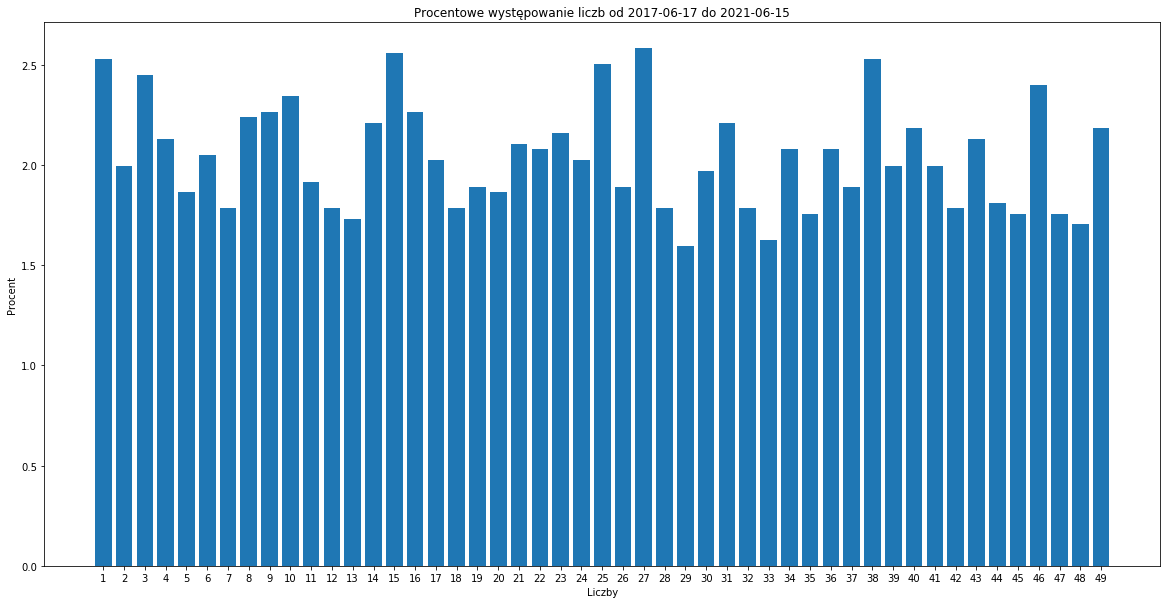

In [276]:
show_results('LOTTO/lotto_results')